# Import modules

In [1]:
import keras
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.utils.vis_utils import model_to_dot
from IPython.display import SVG
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import pandas as pd
import seaborn as sns

Using TensorFlow backend.


In [2]:
from keras.constraints import maxnorm
from keras.callbacks import LearningRateScheduler
from keras import regularizers
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

# from keras.callbacks import TensorBoard


!pip install tensorboardcolab
from tensorboardcolab import *

# Tuning parameters and callbacks

In [0]:
def tuning_parameters():
  global epochs
  global learning_rate
  global batch_size
  global num_classes
  
  epochs = 200
  
  learning_rate=0.01

  batch_size = 64
  
  num_classes = 10

In [0]:
def init_callbacks():
  my_callbacks = []
  
  from keras.callbacks import EarlyStopping
  early_stopping = EarlyStopping(patience = 20)
  
  my_callbacks.append(early_stopping)
  
  tbc=TensorBoardColab()

  my_callbacks.append(TensorBoardColabCallback(tbc))
  
  return my_callbacks

In [5]:
tuning_parameters()
my_callbacks = init_callbacks()

Wait for 8 seconds...
TensorBoard link:
https://5c501d19.ngrok.io


In [0]:
# callbacks[0]

# Data

## Plot image

In [0]:
def plot_images(x, y_true, y_pred=None, size=(5, 5)):
    assert len(x) == len(y_true) == size[0] * size[1]
    
    fig, axes = plt.subplots(size[0], size[1])
    fig.subplots_adjust(hspace=0.5, wspace=0.1)

    for i, ax in enumerate(axes.flat):
        if x[i].shape[-1] == 1:
          ax.imshow(x[i].reshape(x[i].shape[0], x[i].shape[1]))
        else:
          ax.imshow(x[i])

        if y_pred is None:
            xlabel = "True: {0}".format(y_true[i].argmax())
        else:
            xlabel = "True: {0}, Pred: {1}".format(y_true[i].argmax(), 
                                                   y_pred[i].argmax())

        ax.set_xlabel(xlabel)
        
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

## Load dataset

In [0]:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

In [9]:
len(x_train.shape)

4

## Reshaping the data

In [0]:
if len(x_train.shape) < 4:
  x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
  x_test = x_test.reshape(x_test.shape[0], x_train.shape[1], x_train.shape[2], 1)

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255.0
x_test /= 255.0

print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
# print(mean, std)

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples


## Applying One hot encoding for the data

In [0]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

## Show data

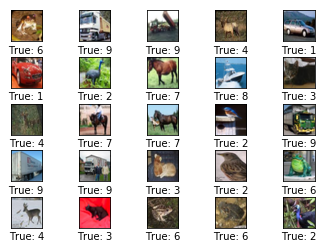

In [13]:
plot_images(x_train[:25], y_train[:25])

# Creating the DNN model

In [14]:
x_train.shape[1:]

(32, 32, 3)

In [0]:
def make_model():
  global model
  weight_decay = 1e-4
  model = Sequential()
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay), input_shape=x_train.shape[1:]))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(32, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(64, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(Conv2D(128, (3,3), padding='same', kernel_regularizer=regularizers.l2(weight_decay)))
  model.add(Activation('elu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  model.add(Flatten())
  
  model.add(Dense(num_classes, activation='softmax'))

In [0]:
def lr_schedule(epoch):
    lrate = 0.01
    if epoch > 75:
        lrate = 0.005
    if epoch > 100:
        lrate = 0.003
    return lrate

In [17]:
make_model()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [0]:
# opt_rms = keras.optimizers.rmsprop(lr=0.001,decay=1e-6)

# model.compile(loss='categorical_crossentropy', optimizer=opt_rms, metrics=['accuracy'])

# model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),\
#                     steps_per_epoch=x_train.shape[0] // batch_size,epochs=125,\
#                     verbose=1,validation_data=(x_test,y_test),
#                     callbacks=[LearningRateScheduler(lr_schedule)])

## Visualization the model

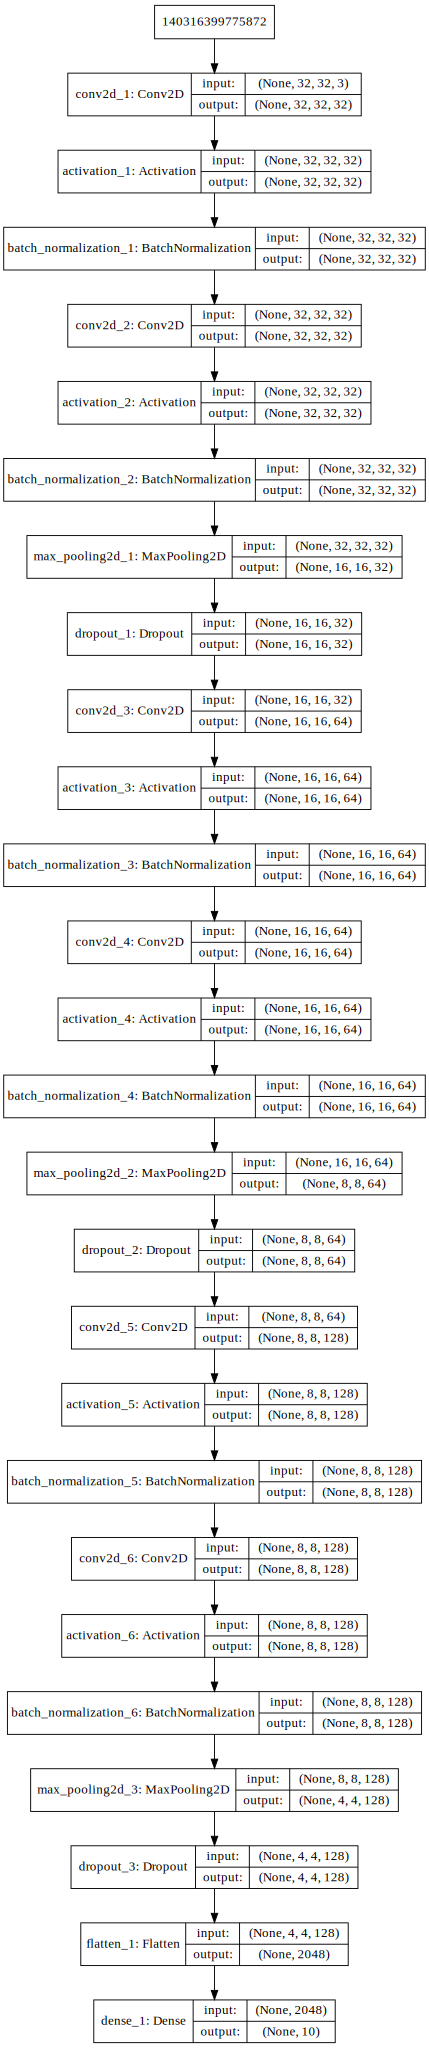

In [19]:
SVG(model_to_dot(model, show_shapes=True).create(prog='dot', format='svg'))

## Optimizer

In [0]:
# optimizer = keras.optimizers.SGD(lr=learning_rate)
opt_rms = keras.optimizers.rmsprop(lr=0.0005,decay=1e-6)

## Compiling the model

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy, 
              optimizer=opt_rms,
              metrics=['accuracy'])

## Training the model

In [22]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          callbacks=my_callbacks)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/200
50000/50000 [==============================] - 14s 271us/step - loss: 1.8072 - acc: 0.4497 - val_loss: 1.4513 - val_acc: 0.5450
Epoch 2/200
50000/50000 [==============================] - 11s 218us/step - loss: 1.1661 - acc: 0.6172 - val_loss: 1.1641 - val_acc: 0.6362
Epoch 3/200
50000/50000 [==============================] - 11s 220us/step - loss: 0.9551 - acc: 0.6879 - val_loss: 1.0055 - val_acc: 0.6877
Epoch 4/200
50000/50000 [==============================] - 11s 216us/step - loss: 0.8433 - acc: 0.7266 - val_loss: 1.0023 - val_acc: 0.6812
Epoch 5/200
50000/50000 [==============================] - 11s 218us/step - loss: 0.7717 - acc: 0.7499 - val_loss: 0.7652 - val_acc: 0.7569
Epoch 6/200
50000/50000 [==============================] - 11s 221us/step - loss: 0.7169 - acc: 0.7707 - val_loss: 0.7382 - val_acc: 0.7739
Epoch 7/200
50000/50000 [==============================] - 11s

## Evaulating the model

In [23]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6102238285064697
Test accuracy: 0.8497


## Prediction the model

In [0]:
y_pred = model.predict(x_test)

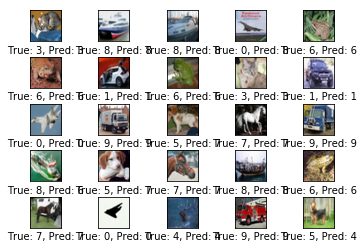

In [25]:
plot_images(x=x_test[:25], y_true=y_test[:25], y_pred=y_pred[:25])

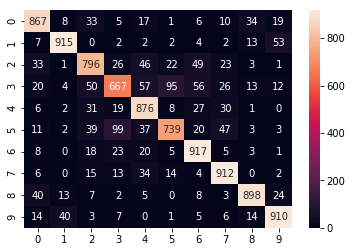

In [26]:
y_result = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(pd.DataFrame(y_result, range(10), range(10)), annot=True, fmt='g')

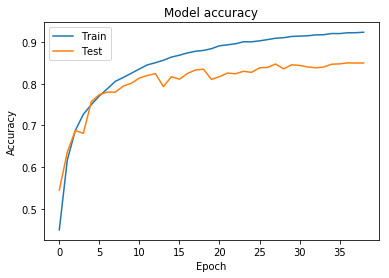

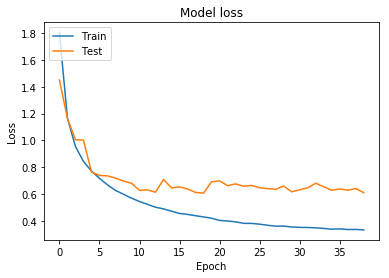

In [27]:
# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


import matplotlib.pyplot as plt


In [0]:
# tbc.save_image(title="test_title", image=image)
